### Data Processing - Final Project
### Alberto Scinetti (13115316)

# Public Opinion on NASA's Climate Posts: Vader Sentiment Analysis and Topic Modeling

This notebook will analysis Public Opinion on NASA's Climate Posts shared on Facebook's comments by users.  An already existing data set of comments will be used for analysis; the dataset can be found at https://www.kaggle.com/datasets/kanchana1990/public-opinion-on-nasas-climate-posts-fb-data. 

The comments, collected from various posts between 2020 and 2023, reflect a wide spectrum of public opinions and sentiments regarding climate change and NASA's related initiatives. 

*Research Question:* 
How is the public opinion oriented towards climate related posts share by NASA on Facebook?

*Sub Questions:* 
- What is the  public sentiment towards NASA's climate-related posts on Facebook? 
- What are the main topics being discussed within the analysed public? 

*Analysis:*
- Vader Sentiment analysis in order to identify public sentiment
- Topic Modeling using LDA (Latent Dirichlet Allocation) approach and Top2Vec library

In [2]:
# import
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import seaborn as sns 
import re
plt.style.use("ggplot")
import nltk
import string
nltk.download('averaged_perceptron_tagger')
nltk.download('maxent_ne_chunker')
nltk.download('words')
nltk.download('vader_lexicon')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
from nltk.stem.wordnet import WordNetLemmatizer
import gensim
from gensim import corpora

/var/folders/cs/84dzr5m11gq8zhw0h8vx96k80000gn/T/ipykernel_82738/3351222373.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/albertoscinetti/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /Users/albertoscinetti/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/albertoscinetti/nltk_data...
[nltk_data]

# Part 1: Sentiment Analysis

In the first part of the analysis, the data will be imported, pre-processed, and a VADER sentiment analysis will be performed in order to identify public sentiment within NASA's climate-related posts shared on Facebook between 2020 and 2023

In [3]:
# read and see the data
df = pd.read_csv("data/climate_nasa.csv")
df.head()

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,Neat comparison I have not heard it before.\n ...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,An excellent way to visualise the invisible! T...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,Does the CO2/ghg in the troposphere affect the...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post! I defo feel the difference - o...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"Yes, and carbon dioxide does not harm the Eart..."


In [4]:
# pre process the data 

df['text'] = df['text'].astype(str) #convert col to str   

def preprocess_text(text):
    """
    This functions takes text as input and removeds digits, converts to lowercase and strips punctuation 
    """
    text = re.sub(r'\d+', '', text)
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    return text

# apply 
df['text'] = df['text'].apply(preprocess_text)

In [5]:
# define the analyser object 
sia = SentimentIntensityAnalyzer()

In [6]:
# try an example 
example = df['text'][15]
print("Example text:")
print(example)
print("\n")
print("Polarity Scores:")
sia.polarity_scores(example)

Example text:
thats an excellent way to illustrate  ppm


Polarity Scores:


{'neg': 0.0, 'neu': 0.619, 'pos': 0.381, 'compound': 0.5719}

In [7]:
# run the polarity score on the entire dataset and store values into a dictionary 
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)): 
    text = row["text"]
    myid = row["profileName"]
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/522 [00:00<?, ?it/s]

In [8]:
# convert to a dataframe and merge with original df to add the polarity scores 
vaders = pd.DataFrame(res).T 
vaders = vaders.reset_index().rename(columns={"index": "profileName"}) 
vaders = vaders.merge(df, how="left")

In [10]:
# sentiment score and metadata are both now in our df 
vaders.head()

,profileName,neg,neu,pos,compound,date,likesCount,commentsCount,text
0,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,0.045,0.718,0.237,0.7702,2022-09-07T17:12:32.000Z,2,NaN,neat comparison i have not heard it before\n i...
1,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,0.000,0.476,0.524,0.7650,2022-09-08T14:51:13.000Z,0,NaN,an excellent way to visualise the invisible th...
2,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,0.000,0.872,0.128,0.2960,2022-09-07T17:19:41.000Z,1,3.0,does the coghg in the troposphere affect the s...
3,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,0.157,0.667,0.176,0.1027,2022-09-08T00:51:30.000Z,4,NaN,excellent post i defo feel the difference one...
4,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,0.100,0.642,0.258,0.6059,2022-09-07T19:06:20.000Z,16,26.0,yes and carbon dioxide does not harm the earth...


## Analysis and Visualizations

Now that the VADER results for each comment have been stored in our dataframe, it is possible to perform various analyses and visualizations to make sense of the polarity scores.

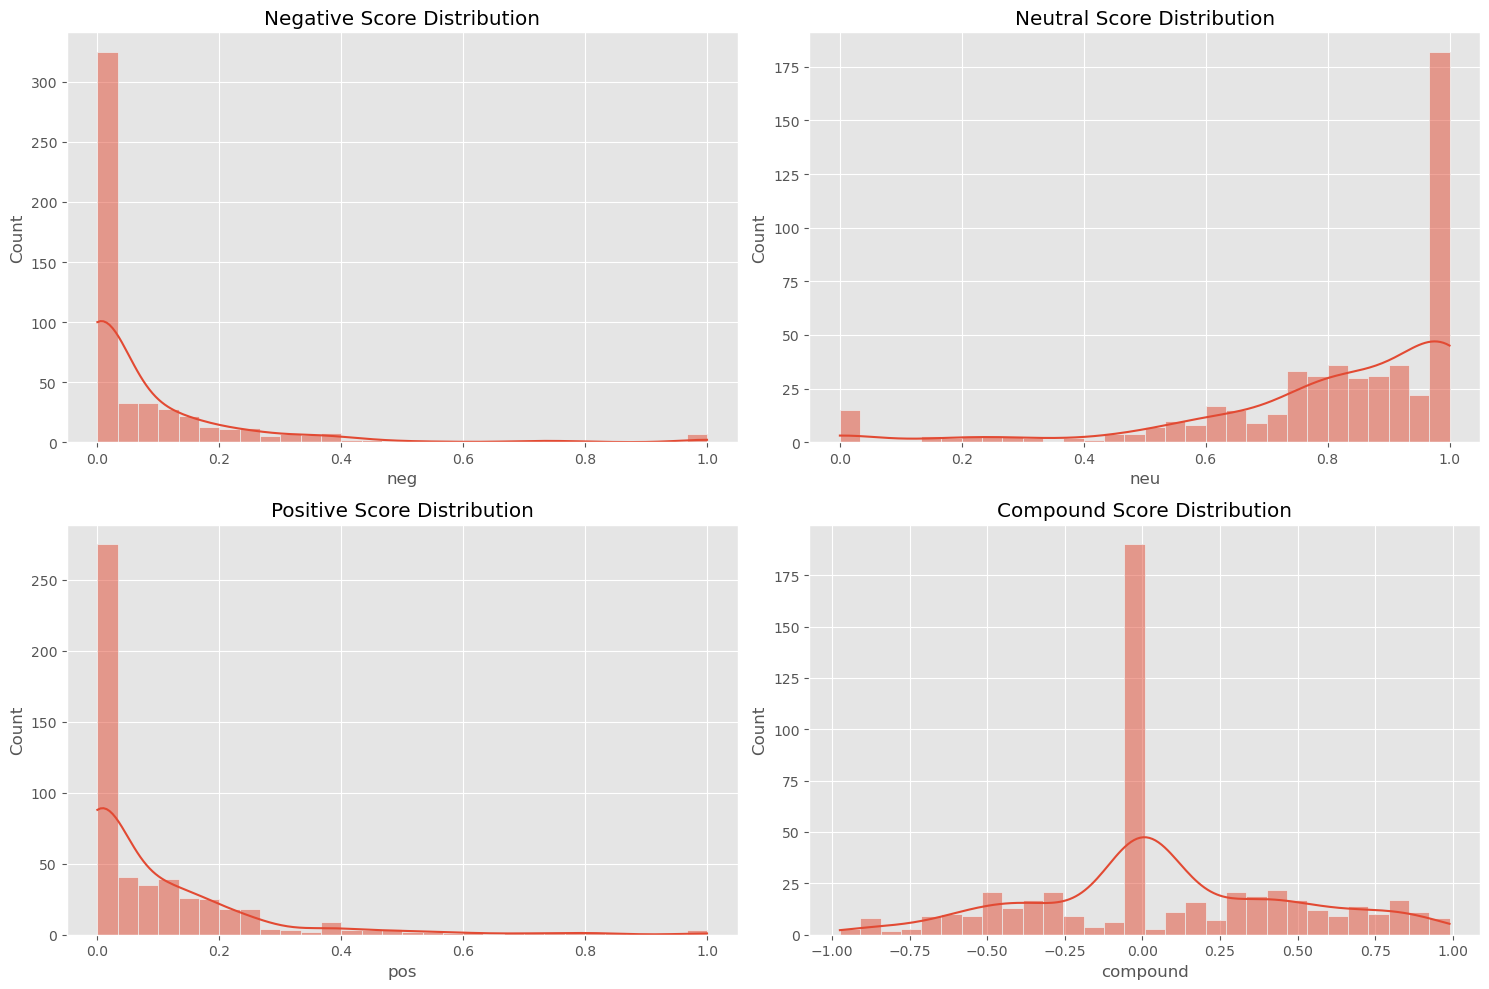

In [11]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Histograms
sns.histplot(vaders['neg'], bins=30, kde=True, ax=axs[0, 0]).set_title('Negative Score Distribution')
sns.histplot(vaders['neu'], bins=30, kde=True, ax=axs[0, 1]).set_title('Neutral Score Distribution')
sns.histplot(vaders['pos'], bins=30, kde=True, ax=axs[1, 0]).set_title('Positive Score Distribution')
sns.histplot(vaders['compound'], bins=30, kde=True, ax=axs[1, 1]).set_title('Compound Score Distribution')

plt.tight_layout()
plt.show()

The sentiment scores from the VADER analysis indicate that most comments in the dataset are perceived as neutral or only slightly positive/negative.

Strongly positive and strongly negative comments are relatively rare.

The compound score distribution, which aggregates the negative, neutral, and positive scores, centers around 0, reinforcing the overall neutral sentiment in the dataset.

-------

For the next part the categorisation of the comments will be shown using a bar chart.

According to Vader's documentation, We define three categories based on the compound score:
- Positive: Compound score ≥ 0.05
- Neutral: -0.05 < Compound score < 0.05
- Negative: Compound score ≤ -0.05

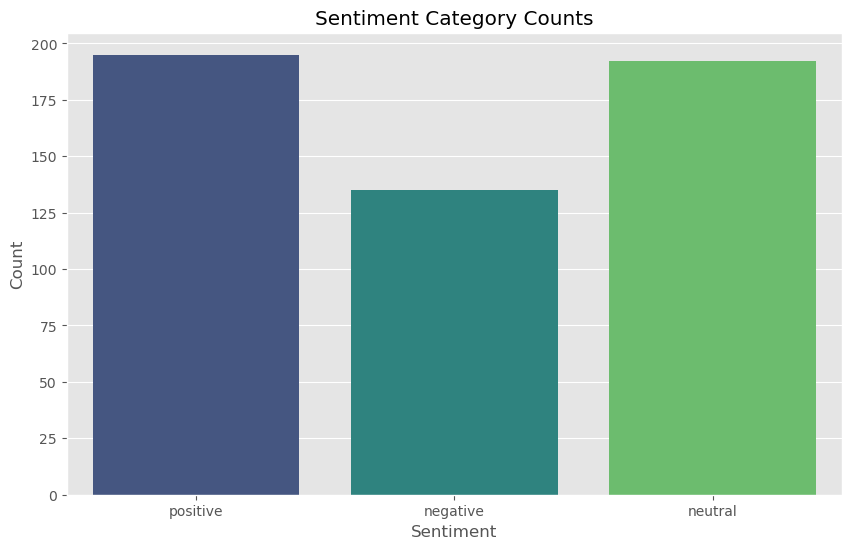

In [13]:
# Categorize the compound scores
vaders['sentiment'] = vaders['compound'].apply(lambda x: 'positive' if x >= 0.05 else ('negative' if x <= -0.05 else 'neutral'))

plt.figure(figsize=(10, 6))
sns.countplot(x='sentiment', data=vaders, palette='viridis', hue = 'sentiment')
plt.title('Sentiment Category Counts')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

The bar chart shows the count of comments categorized as positive, neutral, and negative. 

Positive comments are the most frequent, closely followed by neutral and then negative comments.


# Part 2: Topic Modeling

In the second and final part of the analysis, topic modeling techniques (Latent Dirichlet Allocation and Top2Vec) will be adopted in order to identify the main topics being discussed within the analyzed public opinion regarding NASA's climate-related posts shared on Facebook between 2020 and 2023.

In [11]:
df.head()

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,neat comparison i have not heard it before\n i...
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,an excellent way to visualise the invisible th...
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,does the coghg in the troposphere affect the s...
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,excellent post i defo feel the difference one...
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,yes and carbon dioxide does not harm the earth...


In [12]:
# preprocess the data  

# tokenize words
df["text"] = df["text"].apply(nltk.word_tokenize)

In [13]:
stop_words = set(nltk.corpus.stopwords.words("english"))

# apply the lemmatize method, which reduces the word to its root form
lemma = WordNetLemmatizer()

# define a clean up function 
def clean_up(text_list): 
    """
    Takes a list as an input. Words in the list are excluded of stop words and non alpha characters. Word is lemmatized. 
    New word list is returned with word exclusions
    """
    word_list = []
    for word in text_list:
        word = word.lower()
        if word not in stop_words: 
            if word.isalpha():
                word = lemma.lemmatize(word)
                word_list.append(word)
    return word_list

# clean
df["text"] = df["text"].apply(clean_up)
df.head()

,date,likesCount,profileName,commentsCount,text
0,2022-09-07T17:12:32.000Z,2,4dca617d86b3fdce80ba7e81fb16e048c9cd9798cdfd6d...,NaN,"[neat, comparison, heard, would, say, co, like..."
1,2022-09-08T14:51:13.000Z,0,518ab97f2d115ba5b6f03b2fba2ef2b120540c9681288b...,NaN,"[excellent, way, visualise, invisible, thanks]"
2,2022-09-07T17:19:41.000Z,1,d82e8e24eb633fd625b0aef9b3cb625cfb044ceb8483e1...,3.0,"[coghg, troposphere, affect, stratosphere, war..."
3,2022-09-08T00:51:30.000Z,4,37a509fa0b5177a2233c7e2d0e2b2d6916695fa9fba3f2...,NaN,"[excellent, post, defo, feel, difference, one,..."
4,2022-09-07T19:06:20.000Z,16,e54fbbd42a729af9d04d9a5cc1f9bbfe8081a31c219ecb...,26.0,"[yes, carbon, dioxide, harm, earth, like, peop..."
...,...,...,...,...,...
517,2022-12-22T17:21:37.000Z,0,9e17b1a6422032d47472f0216c73aafda7587e302eed5e...,NaN,"[one, hope, peak]"
518,2022-12-22T17:19:51.000Z,1,48e55d898603a136aefc44771f248bffd67242583a462a...,5.0,"[error, margin, temperature, estimation, year,..."
519,2022-12-22T17:12:57.000Z,3,ca5d2611814cf8c9844ed06d9916d876d2dba94dac5ff2...,NaN,"[volenteerly, help, reducing, globall, warming]"
520,2022-12-22T17:01:12.000Z,1,a87c8aea74c9b97002b368d6143ce9c2809dcaec3103fb...,NaN,"[sergio, yepes]"


## LDA algorithm Topic Modeling Analysis 

In the next step the data is transformed in a format suitable for topic modeling, particularly for the Latent Dirichlet Allocation (LDA) algorithm used later in the notebook. 


Firstly, a dictionary is created mapping each unique term across the text to a unique integer. Then the doc2bow method is applied to transform the dictionary into a matrix 

Example to understand conversion to matrix: 

dictionary : {"climate": 0, "sun": 1, "co2": 3} and climate occurs twice while the other once --> [(0, 2), (1, 1), (2, 1)])



In [14]:
text_list = list(df["text"])

# creating dictionary, where every unique word is assigned an index. 
dictionary = corpora.Dictionary(text_list)

# converting list of text to matrix 
doc_term_matrix = [dictionary.doc2bow(doc) for doc in text_list]

An LDA model object is created and trained in the next step. 
The model is instructed to find 3 topics in the data, mapping terms to topics across 50 passes.



In [28]:
# object for LDA model and run 
Lda = gensim.models.ldamodel.LdaModel

ldamodel = Lda(doc_term_matrix, num_topics=3, id2word=dictionary, passes=50) # decided to identify the 3 main topics

In [26]:
# print results
topics = ldamodel.print_topics(num_topics=3, num_words=3)
for topic in topics:
    print(topic)

(0, '0.012*"climate" + 0.010*"change" + 0.009*"year"')
(1, '0.015*"climate" + 0.014*"change" + 0.013*"earth"')
(2, '0.011*"year" + 0.011*"carbon" + 0.010*"level"')


In [27]:
# print results with more words per topic 
topics = ldamodel.print_topics(num_topics=3, num_words=5)
for topic in topics:
    print(topic)

(0, '0.012*"climate" + 0.010*"change" + 0.009*"year" + 0.007*"temperature" + 0.007*"planet"')
(1, '0.015*"climate" + 0.014*"change" + 0.013*"earth" + 0.008*"co" + 0.008*"global"')
(2, '0.011*"year" + 0.011*"carbon" + 0.010*"level" + 0.008*"water" + 0.008*"dioxide"')


The results provided by the LDA algorithm needs now to be interpreted. 
It was decided to identify 3 main topics within the comments text.

The LDA algorithm identifies these three topics and can print a list of words along with their relative importance within each topic. By examining the words and their associated scores, we can deduce the theme of each topic and classify them accordingly.


- *Topic 0: Long-Term Planet Climate Change*: this topic focuses on long term climate change focusing on changes in temperature around the planet. Words "temperature", "planet" and "year" suggests global perspective on climate change in the long term
  
- *Topic 1: Global Climate Change Implications*: this topic focuses on climate change implications across the planet. Words "earth", "co" and "global" suggest a discussion about climate change implications such as co emissions on a global scale.
  
- *Topic 2: Environmental Impact of Carbon Emissions*: this topic focuses on carbon emissions implications on the environment. Words "carbon", "level", "dioxide" and "year" suggests discussion about how carbon levels, particularly carbon dioxide, have changed over the years. 




## top2vec Topic Modeling Analysis 

In order to learn and experience more with topic modeling another Topic Modeling Analysis is now performed with the top2vec library. 

In [30]:
# import
from top2vec import Top2Vec

In [31]:
# join back words into a string for top2vec analysis 

text_list_top2vec = []
for list in text_list: 
    joined = " ".join(list)
    text_list_top2vec.append(joined)  

In [32]:
# train the Top2Vec model
model = Top2Vec(text_list_top2vec, speed="learn", workers=4)

2024-05-28 16:26:01,001 - top2vec - INFO - Pre-processing documents for training
INFO:top2vec:Pre-processing documents for training
/Users/albertoscinetti/anaconda3/envs/SP/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
2024-05-28 16:26:01,106 - top2vec - INFO - Downloading universal-sentence-encoder-multilingual model
INFO:top2vec:Downloading universal-sentence-encoder-multilingual model
2024-05-28 16:26:04,563 - top2vec - INFO - Creating joint document/word embedding
INFO:top2vec:Creating joint document/word embedding
2024-05-28 16:26:06,381 - top2vec - INFO - Creating lower dimension embedding of documents
INFO:top2vec:Creating lower dimension embedding of documents
2024-05-28 16:26:09,251 - top2vec - INFO - Finding dense areas of documents
INFO:top2vec:Finding dense areas of documents
2024-05-28 16:26:09,297 - top2vec - INFO - Finding topics
INFO:top2vec

In [33]:
# number of topics
num_topics = model.get_num_topics()
print(f"Number of topics: {num_topics}")

Number of topics: 2


In [34]:
# topics 
topics, topic_scores, topic_nums = model.get_topics()

In [35]:
# print topics 
for topic_num in range(num_topics):
    print(f"Topic {topic_num}:")
    print(f"Words: {topics[topic_num]}")
    print(f"Scores: {topic_scores[topic_num]}")
    print("\n")

Topic 0:
Words: ['warming' 'climate' 'atmosphere' 'earth' 'temperature' 'global' 'carbon'
 'change' 'year' 'people' 'co']
Scores: [0.56796855 0.5087385  0.44839793 0.44468084 0.4204553  0.40701264
 0.3403754  0.31667215 0.30160028 0.2742209  0.2593397 ]


Topic 1:
Words: ['co' 'year' 'change' 'people' 'temperature' 'earth' 'warming' 'global'
 'climate' 'carbon' 'atmosphere']
Scores: [0.6784692  0.48676878 0.47926876 0.46219537 0.4504985  0.43652785
 0.42561644 0.4227704  0.4206724  0.37788916 0.37198243]




Results of top2vec algorithm needs now to be intepreted. 

The top2vec algorithm identifies automatically the number of topics based on the data; in this case 2 main topics were found. 

- *Topic 0: Climate Change Global Discussion*: this topic seems to focus on an overall discussion about climate change and how global warming affect the Earth's atmosphere and temperature. 
  
- *Topic 1: Climate change Implications and Impact of Carbon Emissions*: this topic and its words and scoress seems very similar to the first one identified. However, given the high score of "co" (carbon monoxide) we can deduce that it focuses on Carbon emissions implications
  
Overall, the two topic identified seemed very similar given the word and scores similarity. A more extensive set of texts to train the model would be needed. 


# Conclusions

This notebook had as it scope to find an answer to the followings: 

*Research Question:* 
How is the public opinion oriented towards climate related posts share by NASA on Facebook?

*Sub Questions:* 
- What is the  public sentiment towards NASA's climate-related posts on Facebook? 
- What are the main topics being discussed within the analysed public?
----

Given the conducted analysis the following conclusions can be drawn: 

- The sentiment scores from the conducted VADER sentiment analysis indicate that most comments in the dataset are perceived as neutral or only slightly positive/negative. The comments with negative or positive polarity score indicators are only slightly impactful, contributing to a generally more neutral sentiment (strongly positive and strongly negative comments are relatively rare). Overall, the public sentiment towards NASA's climate-related posts on Facebook can be considered neutral




- The main topics identified for analysis by comparing and compiling the results were two. The first topic concerns general discussions about global climate change, focusing on temperature changes around the planet and their impact on global warming. The second one focuses on the implications of climate change, mainly concentrating on carbon emission levels and their effects.

- The main topics discussed within the analyzed comments are highly similar to each other and only slightly vary from each other, given the limitations of the analyzed data. A more extensive set of comments would be needed to closely identify topics within the scrutinised comment sections. This corpus of texts might not have been the best for conducting a topic modeling analysis given its limitations; however, it was still very insightful to learn about the algorithms and their processes.

  